In [19]:
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
import random
import os
import time
import sys
import matching_cpu

%matplotlib inline

from IPython import display


# Model configuration
model      = 'med_gan' 
batch_size = 512 
Z_dim      = 256
tf_lr = 2e-5
sinkhorn_lambda = 50
nr_sinkhorn_iter = 10
plot_every = 500




# Set up weights
D_W1 = tf.Variable(xavier_init([2, 32]))
D_b1 = tf.Variable(tf.zeros(shape=[32]))

D_W2 = tf.Variable(xavier_init([32, 32]))
D_b2 = tf.Variable(tf.zeros(shape=[32]))

D_W3 = tf.Variable(xavier_init([32, 32]))
D_b3 = tf.Variable(tf.zeros(shape=[32]))

if model.startswith('med_gan'):
    D_W4 = tf.Variable(xavier_init([32, 16]))
    D_b4 = tf.Variable(tf.zeros(shape=[16]))
    D_W5 = tf.Variable(xavier_init([16, 1]))
    D_b5 = tf.Variable(tf.zeros(shape=[1]))
    
else:
    D_W4 = tf.Variable(xavier_init([32, 1]))
    D_b4 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3, D_W4, D_b4]

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 128]))
G_b2 = tf.Variable(tf.zeros(shape=[128]))

G_W3 = tf.Variable(xavier_init([128,128]))
G_b3 = tf.Variable(tf.zeros(shape=[128]))

G_W4 = tf.Variable(xavier_init([128, 2]))
G_b4 = tf.Variable(tf.zeros(shape=[2]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3, G_W4, G_b4]



/Users/han/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


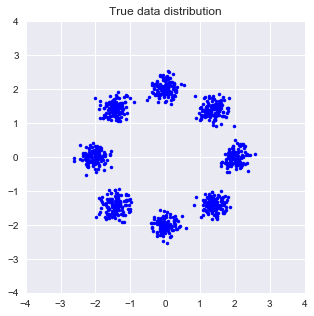

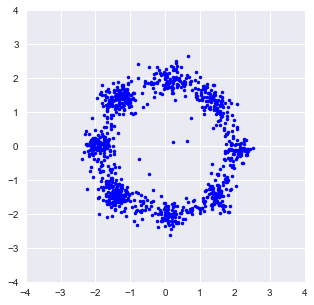

In [20]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_h3 = tf.nn.relu(tf.matmul(G_h2, G_W3) + G_b3)
    G_logit = tf.matmul(G_h3, G_W4) + G_b4
    return G_logit



def medgan_discriminator(x_real, x_fake):
    D_h1_real = tf.nn.relu(tf.matmul(x_real / 4, D_W1) + D_b1)
    D_h2_real = tf.nn.relu(tf.matmul(D_h1_real, D_W2) + D_b2)
    D_h3_real = tf.nn.relu(tf.matmul(D_h2_real, D_W3) + D_b3)
    D_logit_real = tf.matmul(D_h3_real, D_W4) + D_b4
    y_logit_real = tf.matmul(D_logit_real, D_W5) + D_b5

    D_h1_fake = tf.nn.relu(tf.matmul(x_fake / 4, D_W1) + D_b1)
    D_h2_fake = tf.nn.relu(tf.matmul(D_h1_fake, D_W2) + D_b2)
    D_h3_fake = tf.nn.relu(tf.matmul(D_h2_fake, D_W3) + D_b3)
    D_logit_fake = tf.matmul(D_h3_fake, D_W4) + D_b4
    y_logit_fake = tf.matmul(D_logit_real, D_W5) + D_b5
    return D_logit_real, D_logit_fake, y_logit_real, y_logit_fake


def sample_Z(m, n):
    return np.random.normal(size=[m, n])


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

 
 # Set up variables  
X_1 = tf.placeholder(tf.float32, shape=[None, 2])
X_2 = tf.placeholder(tf.float32, shape=[None, 2])
Z_1 = tf.placeholder(tf.float32, shape=[None, Z_dim])
Z_2 = tf.placeholder(tf.float32, shape=[None, Z_dim])
G_sample_1 = generator(Z_1)
G_sample_2 = generator(Z_2)    
if model== 'med_gan':
    D_logit_real, D_logit_fake, y_logit_real, y_logit_fake = \
        medgan_discriminator(tf.concat([X_1, X_2], 0), tf.concat([G_sample_1, G_sample_2], 0))
        

import numpy as np
import tensorflow as tf
from tensorflow.contrib.framework.python.ops import add_arg_scope
from tensorflow.python.framework import function as tff

def adam_updates(params, cost_or_grads, lr=0.001, mom1=0.9, mom2=0.999):
    updates = []
    if type(cost_or_grads) is not list:
        grads = tf.gradients(cost_or_grads, params)
    else:
        grads = cost_or_grads
    t = tf.Variable(1., 'adam_t')
    for p, g in zip(params, grads):
        mg = tf.Variable(tf.zeros(p.get_shape()), p.name + '_adam_mg')
        if mom1>0:
            v = tf.Variable(tf.zeros(p.get_shape()), p.name + '_adam_v')
            v_t = mom1*v + (1. - mom1)*g
            v_hat = v_t / (1. - tf.pow(mom1,t))
            updates.append(v.assign(v_t))
        else:
            v_hat = g
        mg_t = mom2*mg + (1. - mom2)*tf.square(g)
        mg_hat = mg_t / (1. - tf.pow(mom2,t))
        g_t = v_hat / tf.sqrt(mg_hat + 1e-8)
        p_t = p - lr * g_t
        updates.append(mg.assign(mg_t))
        updates.append(p.assign(p_t))
    updates.append(t.assign_add(1))
    return tf.group(*updates)


if model == 'med_gan':
    features_gen = D_logit_fake
    features_dat = D_logit_real
    features_matched = matching_cpu.get_matched_features(features_gen, features_dat, sinkhorn_lambda, nr_sinkhorn_iter)
    avg_entropy = features_matched[-1]
    total_dist_gen = matching_cpu.calc_distance(features_gen, features_dat, features_matched)
    total_dist_disc = total_dist_gen
    
    grad_features_gen = features_matched[0] - features_matched[2]
    grads_gen = tf.gradients(ys=features_gen, xs=theta_G, grad_ys=grad_features_gen)
    
    
    grad_features_gen = features_matched[0] - features_matched[2]
    grad_features_dat = features_matched[1] - features_matched[3]
    grads_disc = tf.gradients(ys=[features_dat, features_gen], xs=theta_D,
                             grad_ys=[grad_features_dat, grad_features_gen])
                                 
    gen_optimizer = adam_updates(theta_G, grads_gen, lr=5 * tf_lr, mom1=0.5, mom2=0.999)
    disc_optimizer = adam_updates(theta_D, grads_disc, lr=-tf_lr, mom1=0.5, mom2=0.999)


def gaussians_8mode(sample_size):
    scale = 2.
    centers = [
        (1,0),
        (-1,0),
        (0,1),
        (0,-1),
        (1./np.sqrt(2), 1./np.sqrt(2)),
        (1./np.sqrt(2), -1./np.sqrt(2)),
        (-1./np.sqrt(2), 1./np.sqrt(2)),
        (-1./np.sqrt(2), -1./np.sqrt(2))
    ]
    centers = [(scale*x,scale*y) for x,y in centers]
    dataset = []
    for i in range(sample_size):
        point = np.random.randn(2)*.2
        center = random.choice(centers)
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype='float32')
    return dataset

data = gaussians_8mode(40000)


data_size = len(data)
data = np.concatenate((data, data[:batch_size,:]), axis=0)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

save_fig_path = 'out_' + model
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)

i = 0 

plt.figure(figsize=(5,5))
plt.plot(data[:1000,0], data[:1000,1], 'b.')
axes = plt.gca()
axes.set_xlim([-4,4])
axes.set_ylim([-4,4])
plt.title('True data distribution')
plt.savefig(save_fig_path + '/real.png', bbox_inches='tight')


np_samples = []

plt.figure(figsize=(5,5))
np_entropy = []

gen_distances = []
disc_distances = []
print('Start Training')
start_time = time.time()
sys.stdout.flush()
for it in range(40000):
    start_idx = it*batch_size%data_size
    X_mb = data[start_idx:start_idx+batch_size, :]
        
    if model == 'med_gan':
        
        sample_size = int(batch_size/2)
        if it < 15000:
        
            e, dd1, _ = sess.run([avg_entropy, total_dist_disc,  disc_optimizer], feed_dict={X_1: X_mb[:sample_size,:], \
                                        X_2: X_mb[sample_size:,:], \
                                        Z_1: sample_Z(sample_size, Z_dim), \
                                        Z_2: sample_Z(sample_size, Z_dim)})
            np_entropy.append(e)
            disc_distances.append(dd1)
            e, dd2, _,= sess.run([avg_entropy,total_dist_gen, gen_optimizer], feed_dict={ \
                                        X_1: X_mb[:sample_size,:], \
                                        X_2: X_mb[sample_size:,:], \
                                        Z_1: sample_Z(sample_size, Z_dim), \
                                        Z_2: sample_Z(sample_size, Z_dim)})



            np_entropy.append(e)
            gen_distances.append(dd2)
        else:
            e, dd2, _,= sess.run([avg_entropy,total_dist_gen, gen_optimizer], feed_dict={ \
                            X_1: X_mb[:sample_size,:], \
                            X_2: X_mb[sample_size:,:], \
                            Z_1: sample_Z(sample_size, Z_dim), \
                            Z_2: sample_Z(sample_size, Z_dim)})


            np_entropy.append(e)
            gen_distances.append(dd2)
            disc_distances.append(0)
        
        
    
    if (it+1) % plot_every == 0:

        samples = sess.run(G_sample_1, feed_dict={Z_1: sample_Z(1000, Z_dim)})

        np_samples.append(samples)
        plt.clf()
        plt.plot(samples[:,0], samples[:,1], 'b.')
        axes = plt.gca()
        axes.set_xlim([-4,4])
        axes.set_ylim([-4,4])

        elapse_time = time.time()
        duration = elapse_time - start_time
        e_tro = sum( np_entropy) / len(np_entropy)
        g_dist = sum(gen_distances) / len(gen_distances)
        d_dist = sum(disc_distances) / len(disc_distances)
        print('sinkhorn iter:', nr_sinkhorn_iter, 'iter:', it, 'duration', duration, 'entropy:', e_tro,
              'gdist:', g_dist, 'd_dist:', d_dist)
        sys.stdout.flush()
        
        np_entropy = []
        gen_distances = []
        disc_distances = []
        plt.savefig('out_' + model + '/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')        
        display.display(plt.gcf()) 
        display.clear_output(wait=True)

        i += 1

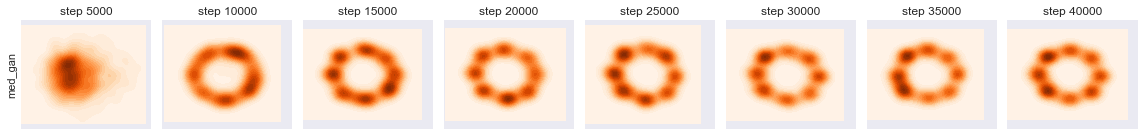

In [23]:
import seaborn as sns
xmax = 4

np_samples_ = np_samples[::10]
cols = len(np_samples_)
bg_color  = sns.color_palette('Oranges', n_colors=256)[0]
plt.figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = plt.subplot(1,cols,1)
    else:
        plt.subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Oranges', n_levels=20, clip=[[-xmax,xmax]]*2)
    plt.xticks([]); plt.yticks([])
    plt.title('step %d'%((i+1)*plot_every*10))
ax.set_ylabel('%s'% model)
plt.gcf().tight_layout()